In [90]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os
import io, zipfile, requests
import statsmodels.api as sm

sector_assets = ["XLB","XLE","XLF","XLI","XLK","XLP","XLU","XLV","XLY"]
tickers = sector_assets + ["SPY"]

TOP_N = 3
COST_BPS = 10
START = "1999-01-01"

In [91]:
import os

DATA_DIR = "data_sector"
REPORTS_DIR = "reports_sector"
FIG_DIR = "figures_sector"  # already used by your chart-saving cell

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

In [92]:
prices = yf.download(tickers, start=START, auto_adjust=True)["Close"]
month_end = prices.resample("ME").last()
monthly_ret = month_end.pct_change()

print("Month-end:", month_end.index.min(), "→", month_end.index.max(), "| cols:", month_end.shape[1])

[*********************100%***********************]  10 of 10 completed

Month-end: 1999-01-31 00:00:00 → 2026-01-31 00:00:00 | cols: 10


In [93]:
# --- Macro data (FRED) ---
def fred_series(series_id: str) -> pd.Series:
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    df = pd.read_csv(url)
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    df = df.rename(columns={"observation_date": "date", series_id: "value"}).set_index("date")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    return df["value"]

# Recession-risk proxy: 10y minus 3m yield spread (daily, %)
t10y3m = fred_series("T10Y3M")
t10y3m_me = t10y3m.resample("ME").mean()  # monthly average

# Leading indicator proxy (monthly): OECD Composite Leading Indicator (US)
lei = fred_series("USALOLITOAASTSAM")
lei_me = lei.copy()
lei_me.index = lei_me.index + pd.offsets.MonthEnd(0)  # align to month-end timestamps

# optional: save for inspection
t10y3m_me.to_csv(os.path.join(DATA_DIR, "macro_T10Y3M_monthly.csv"), header=["T10Y3M"])
lei_me.to_csv(os.path.join(DATA_DIR, "macro_LEI_proxy_OECD_CLI.csv"), header=["LEI_proxy"])
#sanity check 
print(t10y3m_me.head())
print(t10y3m_me.tail())

date
1982-01-31    1.676000
1982-02-28    0.146111
1982-03-31    0.546522
1982-04-30    0.527143
1982-05-31    0.908500
Freq: ME, Name: value, dtype: float64
date
2025-09-30    0.054762
2025-10-31    0.084091
2025-11-30    0.156667
2025-12-31    0.463636
2026-01-31    0.548000
Freq: ME, Name: value, dtype: float64


In [94]:
lei = fred_series("USALOLITOAASTSAM")
lei = fred_series("USALOLITOAASTSAM")
lei_me = lei.copy()
lei_me.index = lei_me.index + pd.offsets.MonthEnd(0)

In [95]:
month_end.to_csv(os.path.join(DATA_DIR, "month_end_prices.csv"))
monthly_ret.to_csv(os.path.join(DATA_DIR, "monthly_returns.csv"))

In [96]:
mom_12_1 = (month_end[sector_assets] / month_end[sector_assets].shift(12) - 1).shift(1)
mom_12_1 = mom_12_1.dropna()

ranks = mom_12_1.rank(axis=1, ascending=False)
weights = (ranks <= TOP_N).astype(int)
weights = weights.div(weights.sum(axis=1), axis=0)

In [97]:
ret_assets = monthly_ret.loc[mom_12_1.index, sector_assets]
spy_ret = monthly_ret.loc[mom_12_1.index, "SPY"]

port_gross = (weights * ret_assets).sum(axis=1).dropna()
spy_ret = spy_ret.loc[port_gross.index]

turnover = weights.loc[port_gross.index].diff().abs().sum(axis=1) / 2
port_net = port_gross - turnover * (COST_BPS / 10000)

print("Months:", len(port_net), "| Avg turnover:", float(turnover.mean()))

Months: 312 | Avg turnover: 0.22222222222222215


In [98]:
# --- 2-state macro regime + volatility targeting (no leverage for now) ---
VOL_TARGET_ON  = 0.15   # keep your current baseline in risk-on
VOL_TARGET_OFF = 0.10   # de-risk in risk-off
VOL_LOOKBACK = 12
LEVERAGE_CAP = 1.0      # still unlevered (decide later)

# Align macro series to portfolio index
yc  = t10y3m_me.reindex(port_net.index)   # yield curve slope (monthly)
lei = lei_me.reindex(port_net.index)      # leading indicator proxy (monthly)

# Recession-risk flag: inverted yield curve (smoothed to reduce noise)
risk_flag = (yc.rolling(3).mean() < 0)

# Growth deterioration flag: leading indicator trending down over 6 months
lei_flag = (lei.pct_change(6) < 0)

# --- Enter OFF (macro trigger), Exit OFF (SPY recovery) ---

# 1) Enter condition (lagged 1 month)
enter_off = (risk_flag & lei_flag).shift(1).fillna(False)

# 2) Exit condition: SPY above 10-month MA (also lagged 1 month)
spy_px = month_end["SPY"].reindex(port_net.index)          # month_end already exists earlier in your notebook
spy_ma = spy_px.rolling(10).mean()
exit_off = (spy_px > spy_ma).rolling(2).min().shift(1).fillna(False)

# 3) Stateful regime: once OFF, stay OFF until exit_off becomes True
risk_off = pd.Series(False, index=port_net.index)

for i in range(1, len(risk_off)):
    if risk_off.iloc[i - 1]:              # if we were OFF last month
        risk_off.iloc[i] = not exit_off.iloc[i]   # stay OFF unless exit condition triggers
    else:                                  # if we were ON last month
        risk_off.iloc[i] = bool(enter_off.iloc[i])  # enter OFF if macro trigger fires

#sanity check
off_months = list(risk_off[risk_off].index.strftime("%Y-%m"))
print("Total OFF months:", len(off_months))
print("First 10:", off_months[:10])
print("Last 10:", off_months[-10:])

# Turn regime into a target volatility series (same index as returns)
vol_target = pd.Series(
    np.where(risk_off, VOL_TARGET_OFF, VOL_TARGET_ON),
    index=port_net.index
)

# Vol targeting scale (lag 1 month to avoid using current month's info)
roll_vol = port_net.rolling(VOL_LOOKBACK).std() * np.sqrt(12)
raw_scale = (vol_target / roll_vol).replace([np.inf, -np.inf], np.nan)

scale = raw_scale.shift(1).clip(lower=0.0, upper=LEVERAGE_CAP)

# Apply overlay
port_net_voltarget = (port_net * scale).dropna()

print("Risk-OFF months (%):", float(risk_off.mean() * 100))
print("Avg scale:", float(scale.dropna().mean()))
print("Ann vol (base):", float(port_net.dropna().std() * np.sqrt(12)))
print("Ann vol (overlay):", float(port_net_voltarget.dropna().std() * np.sqrt(12)))

Total OFF months: 45
First 10: ['2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06']
Last 10: ['2019-07', '2019-09', '2019-11', '2022-12', '2023-01', '2023-02', '2023-04', '2023-06', '2025-06', '2025-09']
Risk-OFF months (%): 14.423076923076922
Avg scale: 0.8941939066943317
Ann vol (base): 0.1469213721484805
Ann vol (overlay): 0.128990233014344


In [99]:
window = slice("2006-01-31", "2011-12-31")

check = pd.DataFrame({
    "T10Y3M_me": yc,
    "T10Y3M_3m_avg": yc.rolling(3).mean(),
    "risk_flag": risk_flag,
    "LEI": lei,
    "LEI_6m_chg": lei.pct_change(6),
    "lei_flag": lei_flag,
    "risk_off_shifted": risk_off
}).loc[window]

print(check.dropna().head(24))
print(check.dropna().tail(24))
print("Counts:", check[["risk_flag","lei_flag","risk_off_shifted"]].sum())

            T10Y3M_me  T10Y3M_3m_avg  risk_flag         LEI  LEI_6m_chg  \
Date                                                                      
2006-01-31   0.080000       0.378897      False  101.263282    0.008141   
2006-02-28   0.029474       0.201888      False  101.350031    0.008286   
2006-03-31   0.096087       0.068520      False  101.382436    0.007555   
2006-04-30   0.268947       0.131503      False  101.356308    0.005790   
2006-05-31   0.273636       0.212890      False  101.294266    0.003364   
2006-06-30   0.188636       0.243740      False  101.232448    0.001030   
2006-07-31   0.011000       0.157758      False  101.192364   -0.000700   
2006-08-31  -0.213913      -0.004759       True  101.196036   -0.001519   
2006-09-30  -0.211000      -0.137971       True  101.255553   -0.001252   
2006-10-31  -0.317143      -0.247352       True  101.349472   -0.000067   
2006-11-30  -0.478095      -0.335413       True  101.463549    0.001671   
2006-12-31  -0.408500    

In [100]:
strategy_ret = port_net_voltarget

In [101]:
def cagr(r):
    n_years = len(r)/12
    return (1+r).prod()**(1/n_years)-1 if n_years>0 else np.nan

def ann_vol(r): return r.std()*np.sqrt(12)
def sharpe0(r): return r.mean()/r.std()*np.sqrt(12)
def max_dd(r):
    eq = (1+r).cumprod()
    peak = eq.cummax()
    return (eq/peak - 1).min()

def slice_period(s, start, end):
    return s.loc[(s.index >= start) & (s.index <= end)]

periods = {
    "Full (1999–2026)": ("1999-01-01", "2026-12-31"),
    "Lost Decade (2000–2010)": ("2000-01-01", "2010-12-31"),
    "Post-GFC Bull (2011–2026)": ("2011-01-01", "2026-12-31"),
}

rows=[]
for name,(a,b) in periods.items():
    rS = slice_period(strategy_ret,a,b).dropna()
    rB = slice_period(spy_ret,a,b).dropna()
    ix = rS.index.intersection(rB.index)
    rS, rB = rS.loc[ix], rB.loc[ix]
    rows.append({
        "Period": name,
        "Months": len(ix),
        "CAGR (Strat)": cagr(rS),
        "CAGR (SPY)": cagr(rB),
        "Sharpe (rf=0)": sharpe0(rS),
        "Sharpe SPY (rf=0)": sharpe0(rB),
        "MaxDD (Strat)": max_dd(rS),
        "MaxDD (SPY)": max_dd(rB),
        "Ann.Vol (Strat)": ann_vol(rS),
        "Ann.Vol (SPY)": ann_vol(rB),
        "Avg Turnover": float(turnover.loc[ix].mean()) if len(ix)>0 else np.nan
    })

regime_df = pd.DataFrame(rows)
regime_df

,Period,Months,CAGR (Strat),CAGR (SPY),Sharpe (rf=0),Sharpe SPY (rf=0),MaxDD (Strat),MaxDD (SPY),Ann.Vol (Strat),Ann.Vol (SPY),Avg Turnover
0,Full (1999–2026),300,0.080646,0.086372,0.667793,0.628379,-0.334306,-0.507848,0.128990,0.150434,0.224444
1,Lost Decade (2000–2010),119,0.047073,0.009927,0.410951,0.143150,-0.334306,-0.507848,0.133966,0.163705,0.240896
2,Post-GFC Bull (2011–2026),181,0.103303,0.139757,0.848277,1.010078,-0.190141,-0.239272,0.125638,0.139862,0.213628


In [102]:
regime_df.to_csv(os.path.join(REPORTS_DIR, "regime_summary_sector.csv"), index=False)
regime_df.to_csv(os.path.join(REPORTS_DIR, "regime_summary_sector.csv"), index=False)
print("Saved:", os.path.join(REPORTS_DIR, "regime_summary_sector.csv"))
weights.to_csv(os.path.join(REPORTS_DIR, "weights_monthly_sector.csv"))
turnover.to_csv(os.path.join(REPORTS_DIR, "turnover_monthly_sector.csv"))
strategy_ret.to_csv(os.path.join(REPORTS_DIR, "strategy_returns_monthly_sector.csv"))
spy_ret.to_csv(os.path.join(REPORTS_DIR, "spy_returns_monthly_sector.csv"))
print("Saved strategy outputs to", REPORTS_DIR)

Saved: reports_sector\regime_summary_sector.csv
Saved strategy outputs to reports_sector


In [103]:
import pandas as pd
import statsmodels.api as sm
import requests
import zipfile
import io
import re

# 1. Robust Fama-French Loader (Fixes the "Footer Text" Crash)
def load_ff_robust(url):
    r = requests.get(url)
    r.raise_for_status()
    z = zipfile.ZipFile(io.BytesIO(r.content))
    fname = z.namelist()[0]
    raw = z.read(fname).decode("utf-8", errors="ignore").splitlines()
    
    # Find start of data (row starting with a date like 192701)
    start_idx = next(i for i, line in enumerate(raw) if re.match(r"^\s*\d{6}", line))
    
    # Read until the next blank line (skips footer text)
    data_lines = []
    for line in raw[start_idx:]:
        if not line.strip(): break # Stop at empty line
        data_lines.append(line)
        
    # Parse
    df = pd.read_csv(io.StringIO("\n".join(data_lines)), sep=",", header=None, index_col=0)
    
    # Clean Index
    df.index.name = "Date"
    df.index = pd.to_datetime(df.index.astype(str), format="%Y%m") + pd.offsets.MonthEnd(0)
    
    # Convert percentages to decimals
    return df.astype(float) / 100

print("Downloading Factor Data...")
# Load 5-Factor (We will only use Mkt, HML)
ff5_raw = load_ff_robust("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip")
ff5_raw.columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]

# Load Momentum
mom_raw = load_ff_robust("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip")
mom_raw.columns = ["MOM"]

# Merge
factors = pd.concat([ff5_raw, mom_raw], axis=1).dropna()

# 2. Run Attribution Regression
# FIX: Align with Vol-Targeted Strategy (port_net_voltarget) for consistency
common = port_net_voltarget.index.intersection(factors.index)
y = port_net_voltarget.loc[common] - factors.loc[common, "RF"]

# FIX: Drop SMB (Size) and others. Keep only Sector-relevant factors.
# Sector Rotation is primarily Market Beta, Value (HML) shifts, and Momentum.
X = factors.loc[common, ["Mkt-RF", "HML", "MOM"]]
X = sm.add_constant(X)

print("\nRunning Regression on Risk-Managed Returns...")
model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

print(model.summary())


Running Regression on Risk-Managed Returns...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     216.0
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           4.10e-74
Time:                        03:49:37   Log-Likelihood:                 787.10
No. Observations:                 299   AIC:                            -1566.
Df Residuals:                     295   BIC:                            -1551.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

C:\Users\cobyb\AppData\Local\Temp\ipykernel_21912\3507654541.py:45: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  factors = pd.concat([ff5_raw, mom_raw], axis=1).dropna()


In [104]:
import re
import pandas as pd
import io, zipfile, requests

def load_kf_mom_monthly():
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
    r = requests.get(url)
    r.raise_for_status()

    z = zipfile.ZipFile(io.BytesIO(r.content))
    fname = z.namelist()[0]
    raw = z.read(fname).decode("utf-8", errors="ignore").splitlines()

    # Find first data row like "192701,  0.12" (YYYYMM at start)
    start = next(i for i, line in enumerate(raw) if re.match(r"^\s*\d{6}", line.strip()))
    tail = raw[start:]

    # Stop at first blank line after the table
    end_rel = next(i for i, line in enumerate(tail) if line.strip() == "")
    table = "\n".join(tail[:end_rel])

    df = pd.read_csv(io.StringIO(table), header=None)
    df = df.iloc[:, :2]
    df.columns = ["YYYYMM", "MOM"]

    idx = pd.to_datetime(df["YYYYMM"].astype(int).astype(str), format="%Y%m") + pd.offsets.MonthEnd(0)
    df.index = idx

    # percent -> decimal
    mom = df["MOM"].astype(float) / 100.0
    return mom

mom = load_kf_mom_monthly().to_frame("MOM")
print("MOM months:", mom.index.min(), "→", mom.index.max())
mom.head()

MOM months: 1927-01-31 00:00:00 → 2025-12-31 00:00:00


,MOM
YYYYMM,
1927-01-31,0.0057
1927-02-28,-0.0150
1927-03-31,0.0352
1927-04-30,0.0436
1927-05-31,0.0278


In [105]:
rS = strategy_ret.loc["2000-01-01":"2010-12-31"].dropna()
rB = spy_ret.loc["2000-01-01":"2010-12-31"].dropna()
ix = rS.index.intersection(rB.index)
rS, rB = rS.loc[ix], rB.loc[ix]

wealth_S = (1+rS).prod()
wealth_B = (1+rB).prod()
ratio = wealth_S / wealth_B

wealth_S, wealth_B, ratio

(np.float64(1.5779908273836827),
 np.float64(1.1029110608134989),
 np.float64(1.4307507499469345))

In [106]:

weights.to_csv(os.path.join(REPORTS_DIR, "weights_monthly.csv"))
turnover.to_csv(os.path.join(REPORTS_DIR, "turnover_monthly.csv"))
strategy_ret.to_csv(os.path.join(REPORTS_DIR, "strategy_monthly_returns.csv"))
spy_ret.to_csv(os.path.join(REPORTS_DIR, "spy_monthly_returns.csv"))


regime_df.to_csv(os.path.join(REPORTS_DIR, "regime_summary.csv"), index=False)

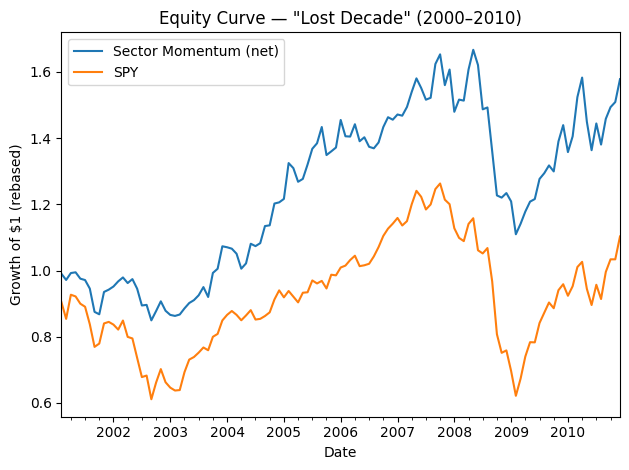

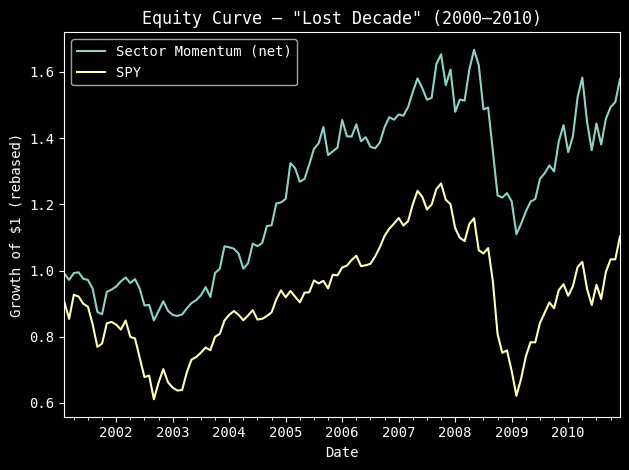

In [107]:
import matplotlib.pyplot as plt
import os

os.makedirs("figures/light", exist_ok=True)
os.makedirs("figures/dark", exist_ok=True)

def plot_equity(start, end, title, fname):
    rS = strategy_ret.loc[start:end].dropna()
    rB = spy_ret.loc[start:end].dropna()
    ix = rS.index.intersection(rB.index)
    rS, rB = rS.loc[ix], rB.loc[ix]

    eqS = (1+rS).cumprod()
    eqB = (1+rB).cumprod()

    # light
    plt.figure()
    eqS.plot(label="Sector Momentum (net)")
    eqB.plot(label="SPY")
    plt.title(title)
    plt.ylabel("Growth of $1 (rebased)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/light/{fname}.png")
    plt.show()

    # dark
    with plt.style.context("dark_background"):
        plt.rcParams["font.family"] = "monospace"
        plt.figure()
        eqS.plot(label="Sector Momentum (net)")
        eqB.plot(label="SPY")
        plt.title(title)
        plt.ylabel("Growth of $1 (rebased)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"figures/dark/{fname}.png", facecolor="black", edgecolor="none")
        plt.show()

plot_equity("2000-01-01","2010-12-31",'Equity Curve — "Lost Decade" (2000–2010)',"moneyshot_lost_decade")

In [108]:
print("strategy_ret equals port_net_voltarget:", strategy_ret.equals(port_net_voltarget))
print("Max abs monthly diff (overlay vs base):", (port_net_voltarget - port_net).abs().max())
print("Months where overlay differs:", int(((port_net_voltarget - port_net).abs() > 1e-12).sum()))

strategy_ret equals port_net_voltarget: True
Max abs monthly diff (overlay vs base): 0.04177319251345731
Months where overlay differs: 129


In [109]:
print("strategy_ret == port_net ?", strategy_ret.equals(port_net))
print("strategy_ret == port_net_voltarget ?", strategy_ret.equals(port_net_voltarget))

# Show final growth of $1 for each (same index)
ix = port_net.dropna().index.intersection(port_net_voltarget.dropna().index).intersection(spy_ret.dropna().index)
eq_base = (1 + port_net.loc[ix]).cumprod().iloc[-1]
eq_overlay = (1 + port_net_voltarget.loc[ix]).cumprod().iloc[-1]
eq_spy = (1 + spy_ret.loc[ix]).cumprod().iloc[-1]

print("Final $1 growth | Base:", eq_base, "| Overlay:", eq_overlay, "| SPY:", eq_spy)

strategy_ret == port_net ? False
strategy_ret == port_net_voltarget ? True
Final $1 growth | Base: 8.312631771545702 | Overlay: 6.951629959032567 | SPY: 7.933410284248375


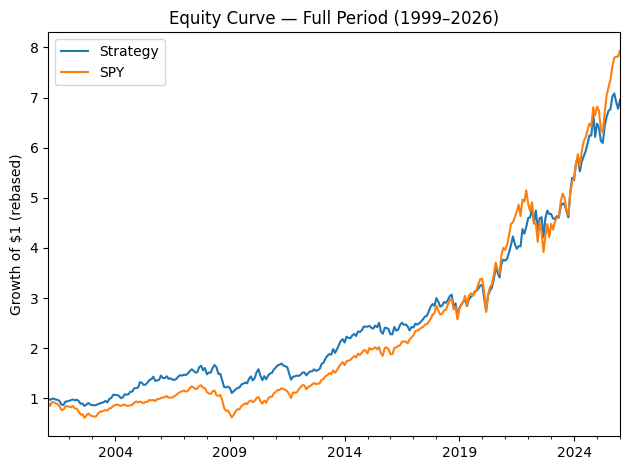

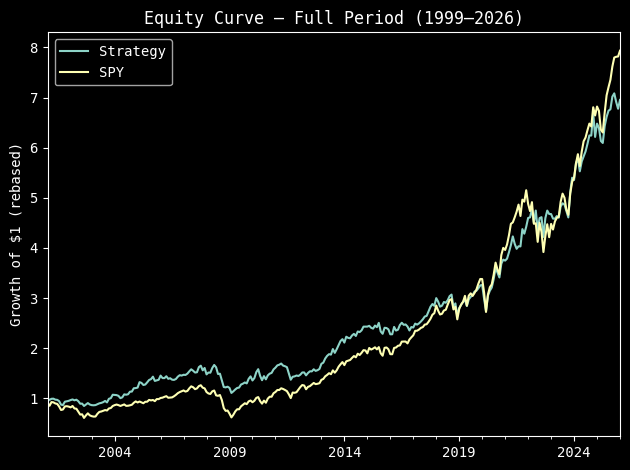

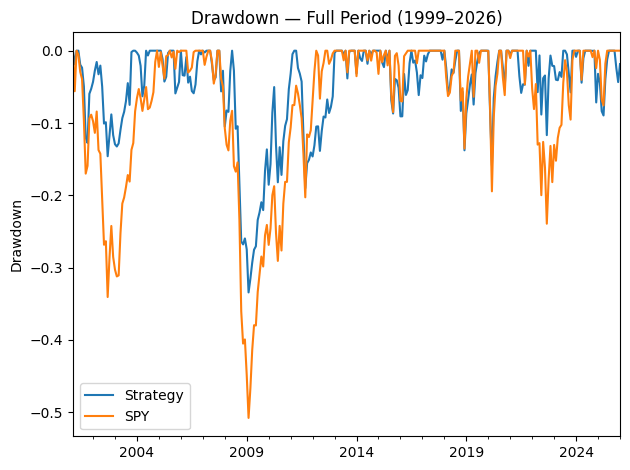

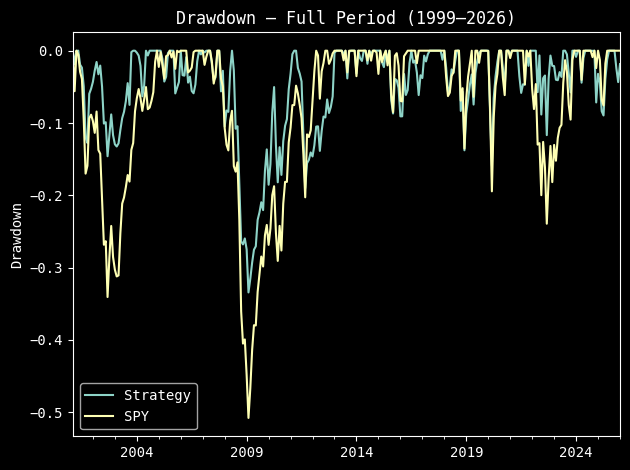

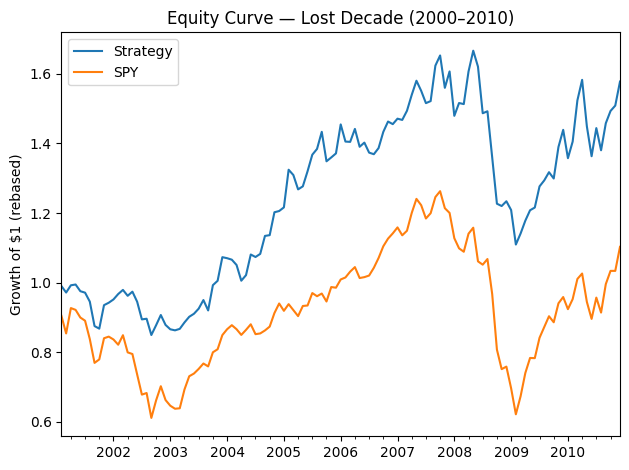

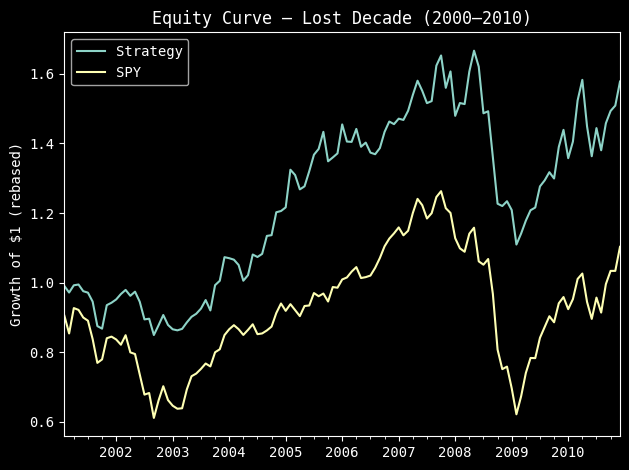

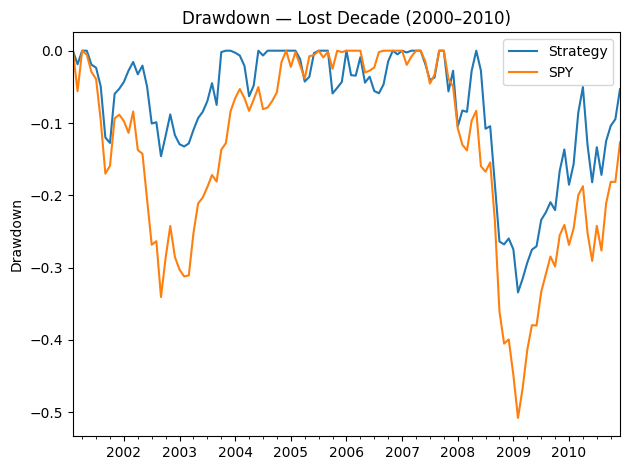

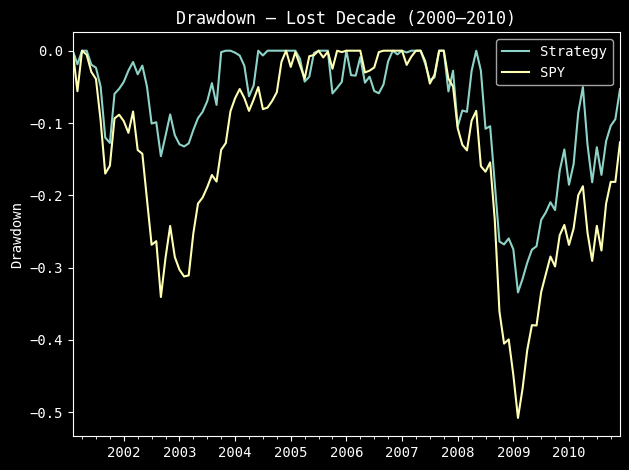

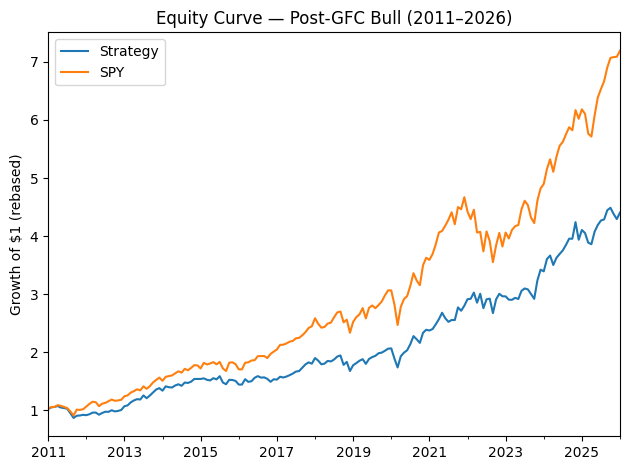

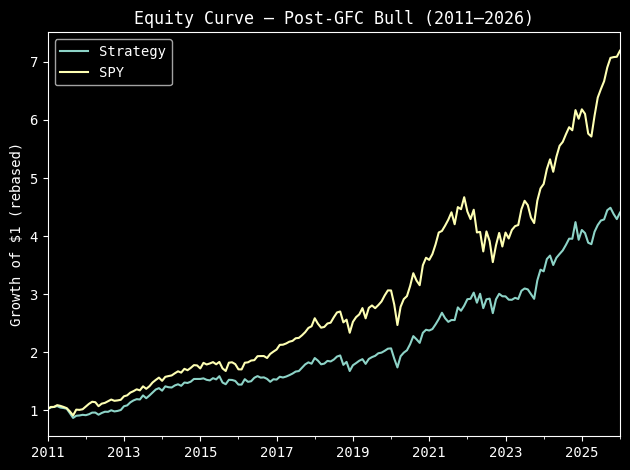

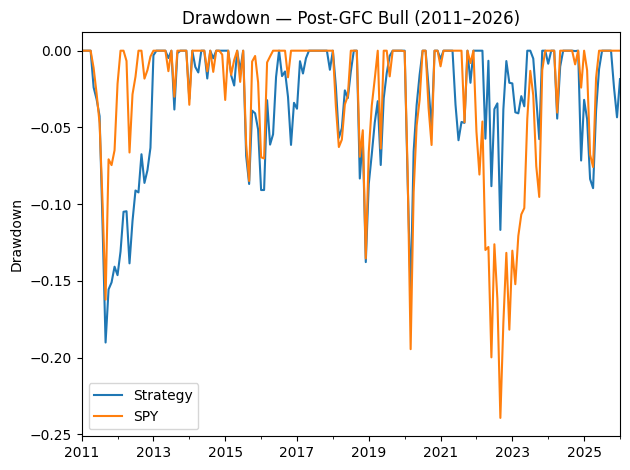

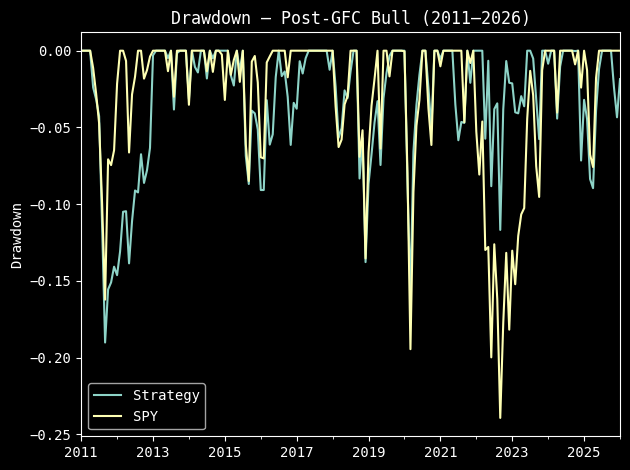

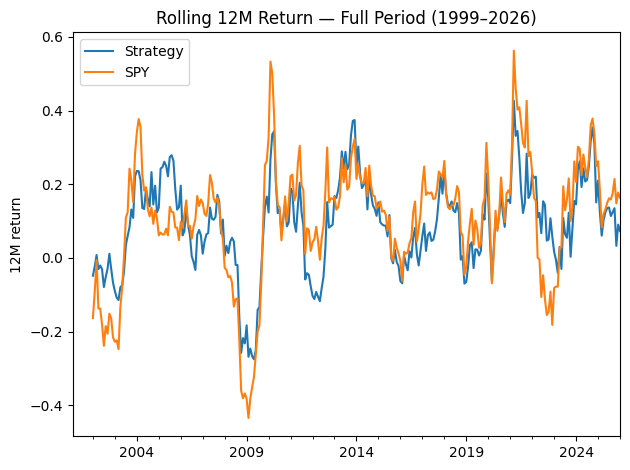

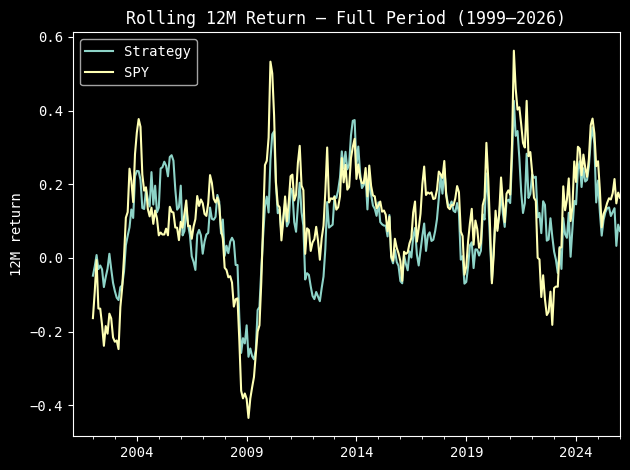

Saved charts to: figures_sector
Light files: ['drawdown_full_1999_2026.png', 'drawdown_lost_decade_2000_2010.png', 'drawdown_post_gfc_2011_2026.png', 'equity_full_1999_2026.png', 'equity_lost_decade_2000_2010.png', 'equity_post_gfc_2011_2026.png', 'risk_overlay_scale_cash.png', 'rolling12_full_1999_2026.png']
Dark files: ['drawdown_full_1999_2026.png', 'drawdown_lost_decade_2000_2010.png', 'drawdown_post_gfc_2011_2026.png', 'equity_full_1999_2026.png', 'equity_lost_decade_2000_2010.png', 'equity_post_gfc_2011_2026.png', 'risk_overlay_scale_cash.png', 'rolling12_full_1999_2026.png']
strategy_ret == port_net ? False
strategy_ret == port_net_voltarget ? True
Final $1 growth | Base: 8.312631771545702 | Overlay: 6.951629959032567 | SPY: 7.933410284248375


In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Make sure you have these defined earlier:
# strategy_ret  -> your headline series (e.g., port_net_voltarget)
# spy_ret       -> benchmark monthly returns aligned to the same calendar

OUTDIR = "figures_sector"
LIGHT_DIR = os.path.join(OUTDIR, "light")
DARK_DIR = os.path.join(OUTDIR, "dark")
os.makedirs(LIGHT_DIR, exist_ok=True)
os.makedirs(DARK_DIR, exist_ok=True)

periods = {
    "Full Period (1999–2026)": ("1999-01-01", "2026-12-31", "full_1999_2026"),
    'Lost Decade (2000–2010)': ("2000-01-01", "2010-12-31", "lost_decade_2000_2010"),
    'Post-GFC Bull (2011–2026)': ("2011-01-01", "2026-12-31", "post_gfc_2011_2026"),
}

def align_period(start, end):
    rS = strategy_ret.loc[start:end].dropna()
    rB = spy_ret.loc[start:end].dropna()
    ix = rS.index.intersection(rB.index)
    return rS.loc[ix], rB.loc[ix]

def equity(r):
    return (1 + r).cumprod()

def drawdown(r):
    eq = equity(r)
    peak = eq.cummax()
    return eq / peak - 1

def save_equity_and_dd(title, start, end, tag):
    rS, rB = align_period(start, end)
    eqS, eqB = equity(rS), equity(rB)
    ddS, ddB = drawdown(rS), drawdown(rB)

    # --- Equity (Light) ---
    plt.figure()
    eqS.plot(label="Strategy")
    eqB.plot(label="SPY")
    plt.title(f"Equity Curve — {title}")
    plt.ylabel("Growth of $1 (rebased)")
    plt.xlabel("")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHT_DIR, f"equity_{tag}.png"))
    plt.show()

    # --- Equity (Dark) ---
    with plt.style.context("dark_background"):
        plt.rcParams["font.family"] = "monospace"
        plt.figure()
        eqS.plot(label="Strategy")
        eqB.plot(label="SPY")
        plt.title(f"Equity Curve — {title}")
        plt.ylabel("Growth of $1 (rebased)")
        plt.xlabel("")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(DARK_DIR, f"equity_{tag}.png"),
                    facecolor="black", edgecolor="none")
        plt.show()

    # --- Drawdown (Light) ---
    plt.figure()
    ddS.plot(label="Strategy")
    ddB.plot(label="SPY")
    plt.title(f"Drawdown — {title}")
    plt.ylabel("Drawdown")
    plt.xlabel("")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHT_DIR, f"drawdown_{tag}.png"))
    plt.show()

    # --- Drawdown (Dark) ---
    with plt.style.context("dark_background"):
        plt.rcParams["font.family"] = "monospace"
        plt.figure()
        ddS.plot(label="Strategy")
        ddB.plot(label="SPY")
        plt.title(f"Drawdown — {title}")
        plt.ylabel("Drawdown")
        plt.xlabel("")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(DARK_DIR, f"drawdown_{tag}.png"),
                    facecolor="black", edgecolor="none")
        plt.show()

# Save equity + drawdown for all periods
for title, (start, end, tag) in periods.items():
    save_equity_and_dd(title, start, end, tag)

# Rolling 12M return (Full only)
rS_full, rB_full = align_period("1999-01-01", "2026-12-31")
roll12_S = (1 + rS_full).rolling(12).apply(np.prod, raw=True) - 1
roll12_B = (1 + rB_full).rolling(12).apply(np.prod, raw=True) - 1

plt.figure()
roll12_S.plot(label="Strategy")
roll12_B.plot(label="SPY")
plt.title("Rolling 12M Return — Full Period (1999–2026)")
plt.ylabel("12M return")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(LIGHT_DIR, "rolling12_full_1999_2026.png"))
plt.show()

with plt.style.context("dark_background"):
    plt.rcParams["font.family"] = "monospace"
    plt.figure()
    roll12_S.plot(label="Strategy")
    roll12_B.plot(label="SPY")
    plt.title("Rolling 12M Return — Full Period (1999–2026)")
    plt.ylabel("12M return")
    plt.xlabel("")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(DARK_DIR, "rolling12_full_1999_2026.png"),
                facecolor="black", edgecolor="none")
    plt.show()

print("Saved charts to:", OUTDIR)
print("Light files:", os.listdir(LIGHT_DIR))
print("Dark files:", os.listdir(DARK_DIR))

print("strategy_ret == port_net ?", strategy_ret.equals(port_net))
print("strategy_ret == port_net_voltarget ?", strategy_ret.equals(port_net_voltarget))

# Show final growth of $1 for each (same index)
ix = port_net.dropna().index.intersection(port_net_voltarget.dropna().index).intersection(spy_ret.dropna().index)
eq_base = (1 + port_net.loc[ix]).cumprod().iloc[-1]
eq_overlay = (1 + port_net_voltarget.loc[ix]).cumprod().iloc[-1]
eq_spy = (1 + spy_ret.loc[ix]).cumprod().iloc[-1]

print("Final $1 growth | Base:", eq_base, "| Overlay:", eq_overlay, "| SPY:", eq_spy)

In [111]:
# scale is the vol targeting
scale_out = scale.reindex(strategy_ret.index).fillna(1.0)  # before vol targeting starts we assume 100% invested
cash_w = 1.0 - scale_out

eff_w = weights.reindex(strategy_ret.index).fillna(0.0).mul(scale_out, axis=0)

eff_w["CASH"] = cash_w

# sanity check
print("Effective weight row-sum stats:\n", eff_w.sum(axis=1).describe())

# save outputs
eff_w.to_csv(os.path.join(REPORTS_DIR, "effective_weights_with_cash.csv"))
scale_out.to_csv(os.path.join(REPORTS_DIR, "vol_target_scale.csv"), header=["scale"])
cash_w.to_csv(os.path.join(REPORTS_DIR, "cash_weight.csv"), header=["cash_weight"])

print("Saved:",
      os.path.join(REPORTS_DIR, "effective_weights_with_cash.csv"),
      os.path.join(REPORTS_DIR, "vol_target_scale.csv"),
      os.path.join(REPORTS_DIR, "cash_weight.csv"))

Effective weight row-sum stats:
 count    3.000000e+02
mean     1.000000e+00
std      4.258935e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64
Saved: reports_sector\effective_weights_with_cash.csv reports_sector\vol_target_scale.csv reports_sector\cash_weight.csv


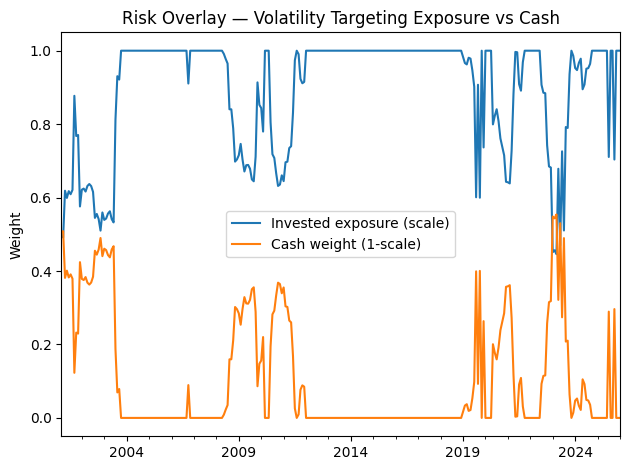

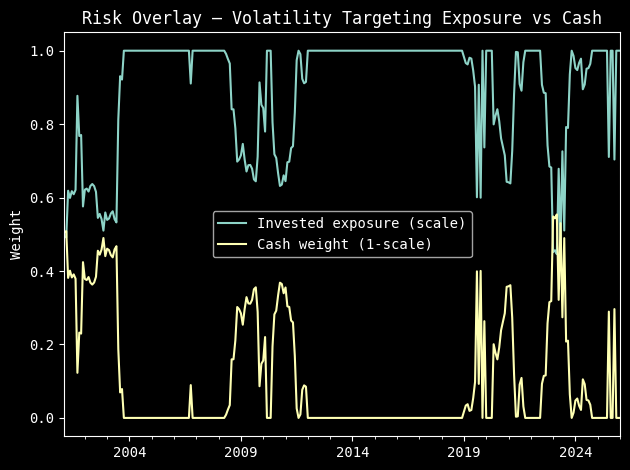

Saved risk overlay charts (light + dark).


In [112]:
import matplotlib.pyplot as plt

plt.figure()
scale_out.plot(label="Invested exposure (scale)")
cash_w.plot(label="Cash weight (1-scale)")
plt.title("Risk Overlay — Volatility Targeting Exposure vs Cash")
plt.ylabel("Weight")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("figures_sector", "light", "risk_overlay_scale_cash.png"))
plt.show()

with plt.style.context("dark_background"):
    plt.rcParams["font.family"] = "monospace"
    plt.figure()
    scale_out.plot(label="Invested exposure (scale)")
    cash_w.plot(label="Cash weight (1-scale)")
    plt.title("Risk Overlay — Volatility Targeting Exposure vs Cash")
    plt.ylabel("Weight")
    plt.xlabel("")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join("figures_sector", "dark", "risk_overlay_scale_cash.png"),
                facecolor="black", edgecolor="none")
    plt.show()

print("Saved risk overlay charts (light + dark).")

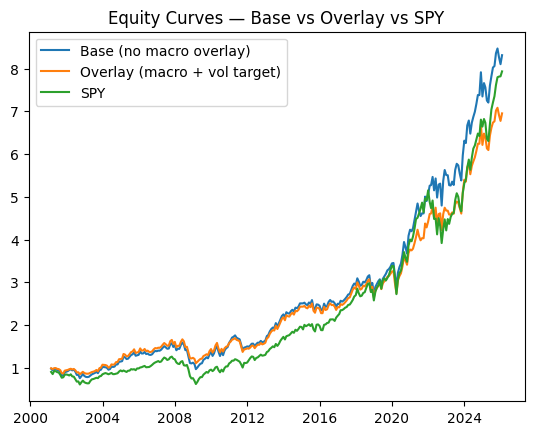

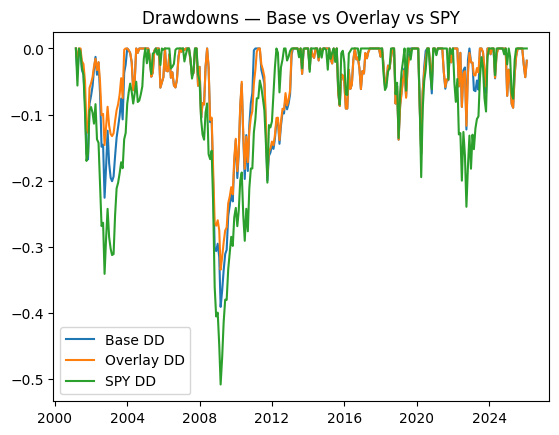

In [113]:
import matplotlib.pyplot as plt

# Align all three series
ix = port_net.dropna().index.intersection(port_net_voltarget.dropna().index).intersection(spy_ret.dropna().index)

eq_base = (1 + port_net.loc[ix]).cumprod()
eq_overlay = (1 + port_net_voltarget.loc[ix]).cumprod()
eq_spy = (1 + spy_ret.loc[ix]).cumprod()

plt.figure()
plt.plot(eq_base.index, eq_base.values, label="Base (no macro overlay)")
plt.plot(eq_overlay.index, eq_overlay.values, label="Overlay (macro + vol target)")
plt.plot(eq_spy.index, eq_spy.values, label="SPY")
plt.title("Equity Curves — Base vs Overlay vs SPY")
plt.legend()
plt.show()

dd_base = eq_base/eq_base.cummax() - 1
dd_overlay = eq_overlay/eq_overlay.cummax() - 1
dd_spy = eq_spy/eq_spy.cummax() - 1

plt.figure()
plt.plot(dd_base.index, dd_base.values, label="Base DD")
plt.plot(dd_overlay.index, dd_overlay.values, label="Overlay DD")
plt.plot(dd_spy.index, dd_spy.values, label="SPY DD")
plt.title("Drawdowns — Base vs Overlay vs SPY")
plt.legend()
plt.show()

In [114]:
import numpy as np
import pandas as pd

def perf_stats(r):
    r = r.dropna()
    ann_ret = (1 + r).prod() ** (12/len(r)) - 1
    ann_vol = r.std() * np.sqrt(12)
    eq = (1 + r).cumprod()
    dd = eq/eq.cummax() - 1
    max_dd = dd.min()
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    return pd.Series({"Ann Return": ann_ret, "Ann Vol": ann_vol, "Sharpe(rf=0)": sharpe, "Max DD": max_dd})

ix = port_net.dropna().index.intersection(port_net_voltarget.dropna().index).intersection(spy_ret.dropna().index)

pd.DataFrame({
    "Base": perf_stats(port_net.loc[ix]),
    "Overlay": perf_stats(port_net_voltarget.loc[ix]),
    "SPY": perf_stats(spy_ret.loc[ix])
})

,Base,Overlay,SPY
Ann Return,0.088403,0.080646,0.086372
Ann Vol,0.144667,0.128990,0.150434
Sharpe(rf=0),0.611075,0.625210,0.574151
Max DD,-0.390599,-0.334306,-0.507848
